# Example usage notebook

This notebook serves as an example usage of the components of this repository, as an extended hands-on README. here all the basic components of the codebase are showcased along with some of its most important functionality. This notebook contains 4 parts regarding the following 4 topics:

- The `RepeaterNetwork` class
- The `AgentGNN` and `GNN` classes (training and testing)
- The relative scaling of the agent
- Parameter dependence of the agent

The first three parts also make up the contents of the `QRN-RL-GNN/src/main.py` file, presented here in a Literate programming setting to make it easier to interpret the files contained in the `QRN-RL-GNN/assets` folder.

In [15]:
from repeaters import RepeaterNetwork
from agent import AgentGNN
from model import GNN
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from stats import train_stats, test_stats
from stats import n_scaling_test
np.set_printoptions(legacy='1.13')
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

## 1) Quantum network simulator

The quantum network simulator is the backbone of this simulation. In th following you can see how you can

- Initialize the system
- Observe its state
- Manually perform actions
- Check if end-to-end entanglement is reached

In [2]:
# Initialize the simulation variables
N = 5
P_E = 0.2
P_S = 0.8
TAU = 1000
net = RepeaterNetwork(n=N, p_entangle=P_E, p_swap=P_S, tau=TAU)

In [3]:
# observe the state
state = net.matrix
state

{(0, 1): [1, 0.0],
 (2, 4): [0.0, 0.0],
 (1, 2): [1, 0.0],
 (0, 4): [0.0, 0.0],
 (3, 4): [1, 0.0],
 (0, 3): [0.0, 0.0],
 (1, 4): [0.0, 0.0],
 (2, 3): [1, 0.0],
 (0, 2): [0.0, 0.0],
 (1, 3): [0.0, 0.0]}

In [4]:
#observe the state used for the GNN
state_gnn = net.tensorState()
state_gnn

Data(x=[5, 2], edge_index=[2, 4], edge_attr=[10])

In [5]:
# Now perform a sequence of actions (entanglements and swaps) and observe how the state transforms
# Start with a network with deterministic actions
net=RepeaterNetwork(n=4, p_entangle=1, p_swap=1)

# Piecewise antangle all the repeaters
net.entangle((0,1))
net.entangle((1,2))
net.entangle((2,3))

# Perform entanglement swapping on the intermediate nodes
net.swapAT(1)
net.swapAT(2)

# Observe the final state
print(net.matrix)

# Ask if the system is in the end-to-end entangled state
print(f' End-to-end entanglement successfully established: {net.endToEndCheck()}')

# Re-initialize the state
net.reset()

# Perform 2 entanglements and one swap and observe the state
net.entangle((1,2))
net.entangle((0,1))
net.swapAT(1)

# Observe all the state description components
print(f'state: {net.tensorState()}\n')
print(f'state.x: {net.tensorState().x}\n')
print(f'edge index (adjecency): {net.tensorState().edge_index}\n')
print(f'edge attributes (entanglement): {net.tensorState().edge_attr}\n')

{(0, 1): [1, 0.0], (1, 2): [1, 0.0], (0, 3): [0.0, 0.999250624625177], (2, 3): [1, 0.0], (0, 2): [0.0, 0.0], (1, 3): [0.0, 0.0]}
 End-to-end entanglement successfully established: True
state: Data(x=[4, 2], edge_index=[2, 3], edge_attr=[6])

state.x: tensor([[0., 1.],
        [0., 0.],
        [1., 0.],
        [0., 0.]])

edge index (adjecency): tensor([[0, 1, 2],
        [1, 2, 3]])

edge attributes (entanglement): tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.9995, 0.0000])



## 2) The Agent and model

The Agent is what combines the GNN model with an RL loop in order to sucessfully learn strategies on how to reach end-to-end entanglement on the repeater network. Here it is showcased how one can

- Initialize the model
- Initialize the agent
- Train the agent
- Evaluate the agent

In [6]:
# Peek at the model architecture
model = GNN()
model

GNN(
  (encoder): Sequential(
    (0): GATv2Conv(2, 16, heads=2)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [7]:
# Initialize training variables
N_TRAIN = 4
P_E_TRAIN = 0.8
P_S_TRAIN = 0.8
TAU_TRAIN = 700

# Intialize tha agent
agent = AgentGNN(n=N_TRAIN, p_entangle=P_E_TRAIN, p_swap=P_S_TRAIN, tau=TAU_TRAIN)

100%|██████████| 1000/1000 [00:00<00:00, 1256.12it/s]


Total links established = 11


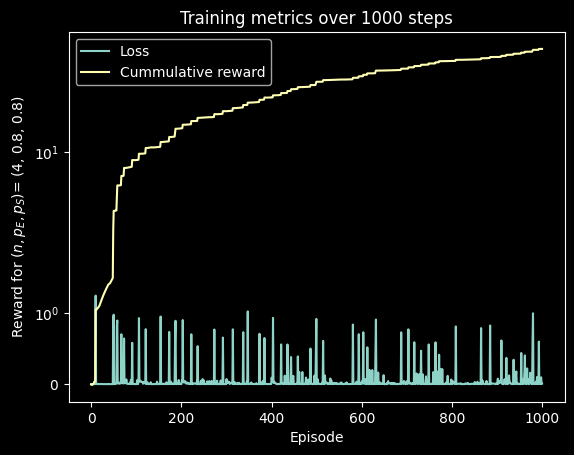

In [ ]:
# Now train the agent. This agent will be used as the trained model for the following simulations
agent.train(episodes = 1_000, plot=True, savefig=False, save_model=False);

100%|██████████| 20000/20000 [00:16<00:00, 1242.73it/s]


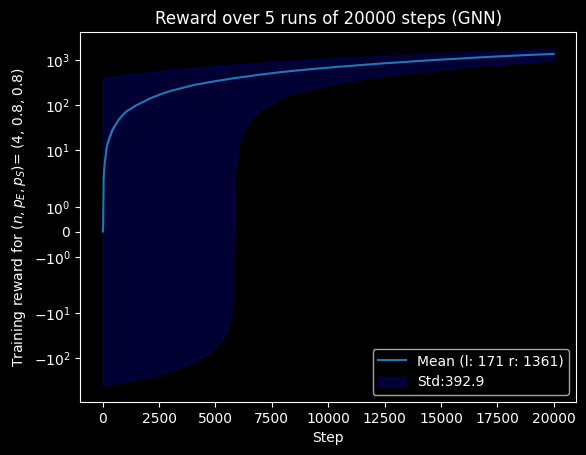

In [9]:
# Lets get some statistics about the average training behaviour of the agent
train_stats(agent, N=5, steps=20_000, savefig=False)

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


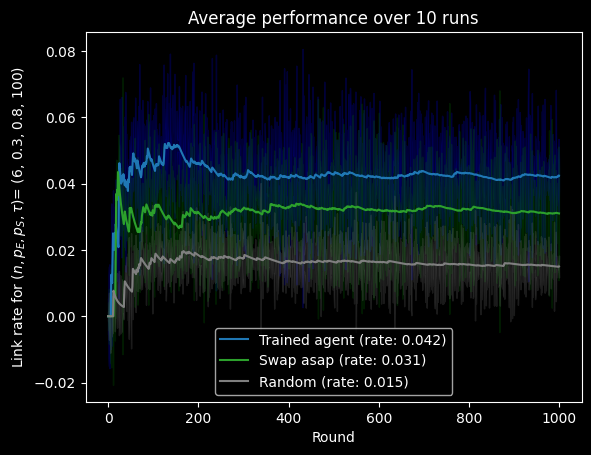

In [10]:
# Now lets get some validation statistics for the agent
test_stats(agent, N=10, n_test = 6, p_entangle=0.3, p_swap=0.8, tau=100, rounds=1000, savefig=False) #Gather testing stats

## 3) The agent relative scaling

All of the crooks of the mater is that by using a GNN, one gets a scalable strategy finder that can operate on networks of arbitrary size, it is therefore imperative that one examines the performance of the agent across many different quantum network lengths. Let $l_{agent}$ be the link-rate (end-to-end links per $n$ operations) of the trained agent. Let $l_{swap-asap}$ be the link-rate of the swap asap strategy over the same number of operations. We define the relative link-rate as

$$
l_{relative} = \frac{l_{agent} - l_{swap-asap}}{l_{swap-asap}}\times 100\%
$$

The larger the value of $l_{relative}$, the better the agent is compared to the swap-asap strategy and vice versa. We perform a test where this value is computed for different sizes $n$ of the quantum network and try to see the general behaviour of $l_{relative}(n)$

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]
/Users/chrischalkias/QRN-RL-GNN/src/stats.py:120: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "gD" (-> color='g'). The keyword argument will take precedence.
  plt.plot(n_test, performance_array, 'gD', color='b', label=f'Relative performance')


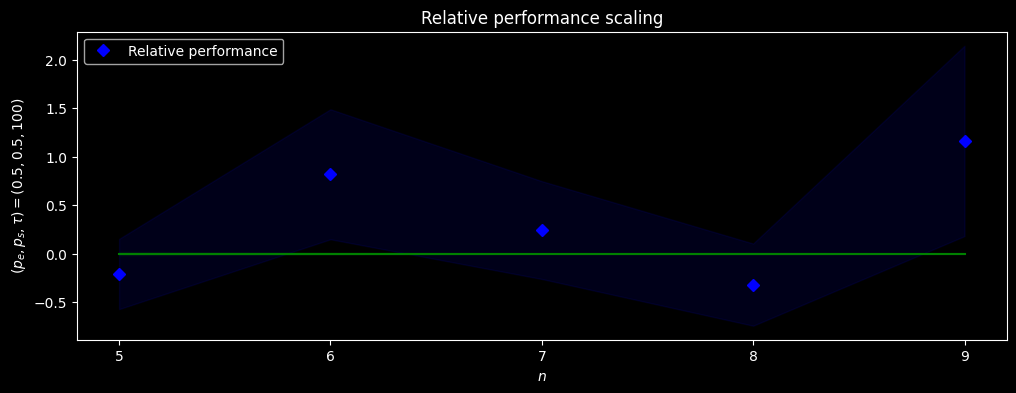

In [11]:
n_scaling_test(N=10, agent=agent, N_range=range(5,10), p_e=0.25, p_s=0.85, tau=100)

## 4) Parameter dependence

In this final part you can see how the relative performance of the agent changes with the choice of parameters for $p_e$ and $p_s$

In [12]:
# The following code is used to gather data from the agent
def data_gatherer():
  N=1
  n_test=5
  p_range = np.linspace(0.1,1,6)
  lt_list, ls_list, lr_list = [], [], []
  t_err_list, s_err_list, r_err_list = [], [], []
  data = {}
  for p_s in tqdm(p_range):
    lt_list, ls_list, lr_list = [], [], []
    for p_e in p_range:
      lt, ls, lr, t_err, s_err, r_err = test_stats(agent, N=N, n_test = n_test, p_entangle=p_e, p_swap=p_s, quiet=True)
      lt_list.append(lt)
      ls_list.append(ls)
      lr_list.append(lr)

    perf_array = (np.array(lt_list) - np.array(ls_list)) / (np.array(ls_list) +1e-5)
    data[p_s] = list(perf_array)
  return data, p_range

In [17]:
# Gathering data takes a while (~1 hour or so) so we can just use some already gathered data on the agent
data = {0.1: [2.9880478087649402, 1.1096316023080341, 11.857707509881422, 1.9970044932601108, 0.713063320022818, 2.2466300549176235, 1.6666666666667, 2.108300044385264, 3.489531405782652, 4.788507581803672],
        0.2: [4.316069057104914, 1.996007984031936, 3.707929264118653, 0.16655562958027997, 3.9946737683089215, 2.270250635670178, 2.270250635670178, 1.2492504497301622, 0.5290383258876087, 1.3326669998334166],
        0.3: [3.9761431411530808, 1.1241568823382464, 2.2972433080303634, 0.7387450026073354, 1.436422682987759, 2.398081534772183, 0.9995386744579425, 0.68936991589687, 0.6174291426555334, 1.1148700599723207],
        0.4: [18.774703557312254, 0.6661337596589396, 1.3559805880673705, 2.3824162311712267, 0.812195426714982, 1.3471232400486703, 0.6313795643481006, 0.8105479304009507, 1.5660402505664393, 0.717727878601456],
        0.5: [1.123315027458812, 1.4273479874393373, 0.499785806083107, 0.31698039598166383, 0.9683868549294012, 0.6827270067297372, 0.2744452285736689, 1.2158218956014262, 0.254841997961264, 0.77981284491722],
        0.6: [0.9986684420772304, 0.1303667651660005, 0.564922649052668, 0.04544215214032528, 0.2999280172758539, 0.4129357558897678, 0.3278043663541599, 0.3870218667354706, 0.28566531451751126, 0.02777314891962457],
        0.7: [0.9982886480319453, 0.11533138551437792, 0.0571232720210215, 0.24437927663734083, 0.47605446063029594, 0.6198512357034314, 0.08331944675887347, 0.3999261674767737, 0.6561269761919638, 0.08432515780850956],
        0.8: [1.3315579227696408, 0.636016718153734, 0.4165278240586473, -0.066648893628366, 0.28839498577251377, 0.11938160329493214, 0.19997000449932514, 0.17718827519870387, 0.2823130852114996, -0.2661640721664316],
        0.9: [2.7932960893854757, 1.0863897097166695, 0.11360538035081359, -0.11664333799906702, -0.14082126964456718, 0.012984989352308816, -0.08432515780850956, 0.08044867374615008, -0.06086321427329304, -0.5851591781106025],
        1.0: [0.12490632025980504, 0.0, 0.24437927663734124, 0.24522749566135968, -0.1304121022430879, 0.05554629783924914, 0.05554814913567079, -0.11402308528926794, -0.18703421287370886, -0.7752203759152172]}

p_range = [key for key in data.keys()]

Text(0.5, 1.0, 'Agent relative performance (n=6)')

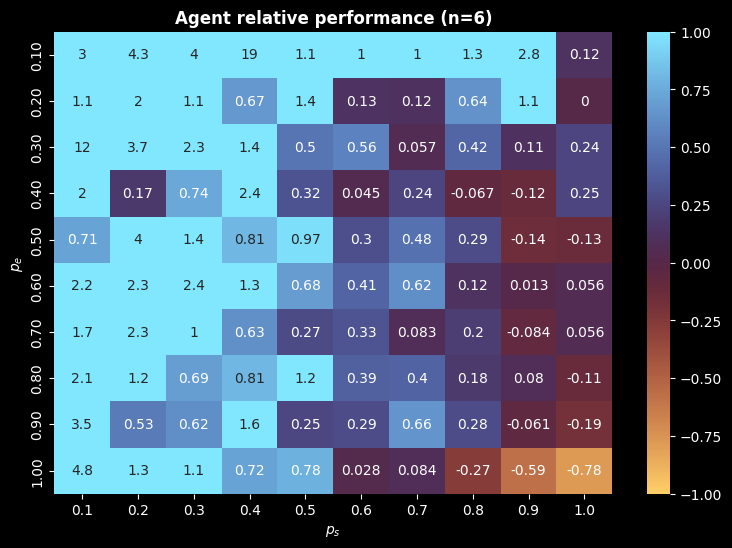

In [18]:
# Now we can generate the heatmap
data = {round(key, 2): value for key, value in data.items()}
index = [f"{num:.2f}" for num in p_range]

df = pd.DataFrame(data, index=index)
df.index.name = "$p_e$"
df.columns.name = "$p_s$"
f, ax = plt.subplots(figsize=(9, 6))
sns.set_theme

sns.heatmap(df, annot=True, linewidths=0.0, ax=ax,cmap='managua',  vmin=-1, vmax=1)#cmap='managua'
plt.title("Agent relative performance (n=6)", fontsize=12, fontweight='bold')

Notice that the more stochastic the entanglement and swapping success probabilities become (top left corner) the better the agent becomes compared to the swap asap strategy.